# Data Loading with Torch Datasets

This recipe demonstrates how to load samples from a FiftyOne dataset into **PyTorch** using `FiftyOneTorchDataset` and custom `GetItem` definitions. This is useful when you want to train or evaluate models in Torch while flexibly choosing which fields (such as filepaths, labels, or detections) to include. Specifically, it covers:

* Loading an example dataset from the [Dataset Zoo](https://voxel51.com/docs/fiftyone/user_guide/dataset_zoo/index.html)
* Defining custom `GetItem` classes to map dataset fields into Torch-ready formats
* Creating a `FiftyOneTorchDataset` and using it with a PyTorch `DataLoader`
* Retrieving custom batches of samples for training and visualization


## Setup

If you haven't already, install FiftyOne:

In [ ]:
!pip install fiftyone

In this tutorial, we'll use [PyTorch](https://pytorch.org/) for working with tensors and inspecting sample data. To follow along, you'll need to install `torch` and `torchvision`, if necessary:


In [ ]:
!pip install torch torchvision

## Import Libraries

In [19]:
import torch
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

In [20]:
import fiftyone as fo
import fiftyone.zoo as foz
from fiftyone.utils.torch import GetItem, FiftyOneTorchDataset

## Load Dataset

In [ ]:
# Load a dataset
dataset = foz.load_zoo_dataset("quickstart")

# make sure its persistent
dataset.persistent = True

## GetItem
In this step, we define a `GetItem` that retrieves the `filepath` from each sample in the dataset. This allows us to map the dataset’s fields into the format expected by our workflow.

In [3]:
# define a GetItem

class FilepathGetItem(GetItem):
    # required_keys lists the keys that this GetItem will use
    # they don't have to be specific to your field schema
    # they are simply names assigned for expected fields
    # we can later map a specific dataset's field names to the keys expected by a GetItem
    # here we only need the filepath of the sample
    @property
    def required_keys(self):
        return ["filepath"]

    # __call__ implements the transformation from a sample dict to model input
    # sample_dict is a dictionary with the keys listed in required_keys
    # and the corresponding values from the sample
    def __call__(self, sample_dict):
        return sample_dict["filepath"]

In [ ]:
# when instantiating a GetItem, we can pass a field_mapping dictionary
# to map the expected keys to specific fields in the dataset
# by default, keys are mapped to fields of the same name
# but we can override this with field_mapping

dummy_sample_dict = {
    'filepath': '/path/to/image.jpg'
}

# without a field mapping, the key "filepath" maps to the field "filepath"
get_item = FilepathGetItem()
print(get_item(dummy_sample_dict))  # prints: /path/to/image.jpg

## FiftyOneTorchDataset
We can then define a FiftyOneTorchDataset using our GetItem

In [ ]:
torch_dataset = dataset.to_torch(FilepathGetItem())

In [ ]:
torch_dataset[0]  # prints the filepath of the first sample in the dataset

In [ ]:
# notice that torch_dataset is a standard PyTorch Dataset
print(isinstance(torch_dataset, torch.utils.data.Dataset))  # prints: True

In [12]:
# you can use it in a DataLoader as normal
dataloader = torch.utils.data.DataLoader(
    torch_dataset,
    batch_size=8,
    worker_init_fn=FiftyOneTorchDataset.worker_init
)

In [ ]:
for i, batch in enumerate(dataloader):
    print(f"Batch {i}: {batch}")
    if i >= 2:
        break

## FieldMapping
When working with `FiftyOneTorchDataset` and `GetItem`, you can use the `field_mapping` argument to connect the keys expected by your `GetItem` to the actual fields in your dataset.  

This allows you to flexibly adapt the same `GetItem` across datasets that may have different field names or more complex field structures.

In [41]:
class DetectionGetItem(GetItem):
    @property
    def required_keys(self):
        return ["filepath", "detections_field"]

    def __call__(self, sample_dict):
        return {
            "filepath" : sample_dict["filepath"],
            "labels" : [det.label for det in sample_dict["detections_field"].detections],
            "boxes" : [det.bounding_box for det in sample_dict["detections_field"].detections]
        }

In [42]:
def plot_boxes(d):
    img = Image.open(d["filepath"])
    w, h = img.size

    fig, ax = plt.subplots(1)
    ax.imshow(img)
    for label, box in zip(d["labels"], d["boxes"]):
        x, y, bw, bh = box
        rect = patches.Rectangle((x * w, y * h), bw * w, bh * h, linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        ax.text(x * w, y * h, label, color='white', fontsize=12, backgroundcolor='red')
    plt.show()

In [43]:
# this dataset will use the "ground_truth" field for the "detections_field" key
gt_dataset = dataset.to_torch(
    DetectionGetItem(field_mapping={"detections_field": "ground_truth"})
)
# meanwhile, this dataset will use the "predictions" field for the "detections_field" key
pred_dataset = dataset.to_torch(
    DetectionGetItem(field_mapping={"detections_field": "predictions"})
)

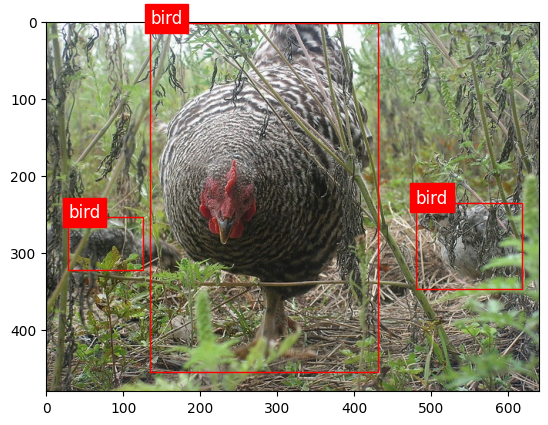

In [44]:
plot_boxes(gt_dataset[0])

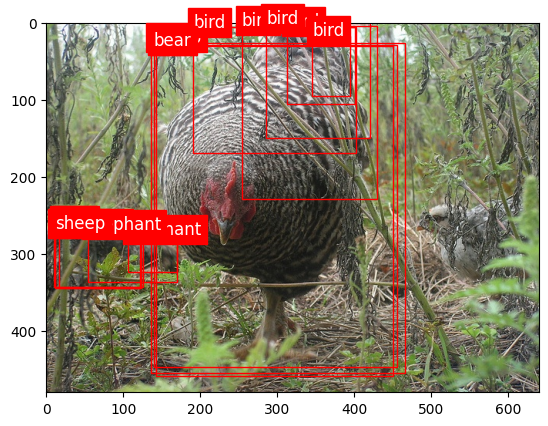

In [45]:
plot_boxes(pred_dataset[0])

In [49]:
# again we can use these datasets in DataLoaders as normal
# here we have to use a collate function because the number of detections
# per image can vary, so we can't simply stack them into a tensor
def detection_collate(batch):
    filepaths = [item["filepath"] for item in batch]
    labels = [item["labels"] for item in batch]
    boxes = [item["boxes"] for item in batch]
    return {
        "filepaths": filepaths,
        "labels": labels,
        "boxes": boxes
    }
gt_dataloader = torch.utils.data.DataLoader(
    gt_dataset,
    batch_size=4,
    worker_init_fn=FiftyOneTorchDataset.worker_init,
    collate_fn=detection_collate
)

In [ ]:
for batch in gt_dataloader:
    print(batch['filepaths'])
    print(batch['labels'])
    print(batch['boxes'])
    break

With this, you can now load batches of samples directly from your FiftyOne dataset using PyTorch, while customizing exactly which fields are retrieved.
